In [1]:
import torch
import torch.nn as nn

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class CardNet(nn.Module):
    def __init__(self, num_suits=4, num_ranks=14):
        super().__init__()
        self.inplanes = 64
        # Stem
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Layers (Bottleneck stacks: 3, 4, 6, 3)
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.suit_fc = nn.Linear(512 * 4, num_suits)
        self.rank_fc = nn.Linear(512 * 4, num_ranks)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaiming Normal is preferred for ReLU networks
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        for m in self.modules():
            if isinstance(m, Bottleneck):
                nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * 4:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * 4, stride),
                nn.BatchNorm2d(planes * 4),
            )
        layers = [Bottleneck(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * 4
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.suit_fc(x), self.rank_fc(x)

In [2]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CardNet(num_suits=5, num_ranks=14).to(DEVICE)
count_parameters(model)

Total Parameters:     23,546,963
Trainable Parameters: 23,546,963


In [3]:
import kagglehub
import shutil
import os
import pandas as pd

cache_path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

local_path = os.path.join(os.getcwd(), "cards_data")
if not os.path.exists(local_path):
    shutil.move(cache_path, local_path)
    print(f"Dataset moved to: {local_path}")
else:
    print("Dataset already exists in current folder.")

csv_file = os.path.join(local_path, "cards.csv")

if os.path.exists(csv_file):
    print("Cleaning CSV file...")
    df = pd.read_csv(csv_file)
    
    df.columns = df.columns.str.strip()
    
    initial_count = len(df)
    df = df[~df['filepaths'].str.contains('output', case=False, na=False)].copy()
    
    df = df.reset_index(drop=True)
    
    df.to_csv(csv_file, index=False)
    
    removed = initial_count - len(df)
    print(f"Cleanup Complete: Removed {removed} 'output' rows.")
    print(f"Final CSV saved at: {csv_file}")
else:
    print(f"Warning: Could not find CSV at {csv_file}")



/home/tudor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset already exists in current folder.
Cleaning CSV file...
Cleanup Complete: Removed 0 'output' rows.
Final CSV saved at: /home/tudor/rocm/card-recognition/cards_data/cards.csv


In [4]:
class RandomQuadrantCrop(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img):
        # Only apply the quadrant crop based on probability p
        if torch.rand(1).item() > self.p:
            return img
            
        c, h, w = img.shape
        half_h, half_w = h // 2, w // 2
        
        quadrants = [
            img[:, 0:half_h, 0:half_w],  # Top-Left
            img[:, 0:half_h, half_w:w],  # Top-Right
            img[:, half_h:h, 0:half_w],  # Bottom-Left
            img[:, half_h:h, half_w:w]   # Bottom-Right
        ]
        
        choice = torch.randint(0, 4, (1,)).item()
        return quadrants[choice]

In [5]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2
import random
# CONFIG
csv_path = './cards_data/cards.csv'
data_root = './cards_data'
df = pd.read_csv(csv_path)
BATCH_SIZE = 64
def pick_corner(crops):
    return crops[random.randint(0, 3)]


# Might contain too many images without a suit or rank visible
# train_tfs = v2.Compose([
#     v2.ToImage(),
#     v2.Resize((224, 224)),
#     v2.RandomPerspective(distortion_scale=0.6, p=0.5), 
#     v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 0.8), ratio=(0.75, 1.33)),
#     v2.RandomAffine(degrees=30, shear=10, translate=(0.1, 0.1), scale=(1, 1.2)),
#     v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.7, hue=0.015),
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.RandomVerticalFlip(p=0.2),
#     v2.ToDtype(torch.float32, scale=True), 
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     v2.RandomErasing(p=0.4, scale=(0.02, 0.2), ratio=(0.3, 3.3))
# ])

# A balanced pipeline
train_tfs = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
    transforms.RandomAffine(degrees=30, shear=10),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.7, hue=0.015),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) 
# train_tfs = v2.Compose([
#     v2.ToImage(),
#     v2.Resize((256, 256)), 
#     RandomQuadrantCrop(p=0.3),
#     v2.RandomPerspective(distortion_scale=0.3, p=0.5),
#     v2.RandomAffine(degrees=30, shear=5, translate=(0.1, 0.1)),
#     v2.RandomResizedCrop(224, scale=(0.9, 1.0)),
#     v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.7, hue=0.015),
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.RandomVerticalFlip(p=0.2),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

val_tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- DATA LOADERS ---
tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_df = df[df['data set'] == 'train'].reset_index(drop=True)
val_df   = df[df['data set'] == 'valid'].reset_index(drop=True)
test_df  = df[df['data set'] == 'test'].reset_index(drop=True)

class PlayingCardDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
        self.suit_map = {'clubs': 0, 'diamonds': 1, 'hearts': 2, 'spades': 3, 'joker': 4}
        self.rank_map = {
            'two': 0, 'three': 1, 'four': 2, 'five': 3, 'six': 4, 'seven': 5, 
            'eight': 6, 'nine': 7, 'ten': 8, 'jack': 9, 'queen': 10, 'king': 11, 'ace': 12, 'joker': 13
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx]['filepaths'])
        image = Image.open(img_path).convert('RGB')
        
        label_str = self.data.iloc[idx]['labels'].lower()
        parts = label_str.split(' of ')
        
        if len(parts) == 2:
            rank_str, suit_str = parts[0], parts[1]
        else:
            rank_str, suit_str = 'joker', 'joker'
            
        rank_idx = self.rank_map[rank_str]
        suit_idx = self.suit_map[suit_str]

        if self.transform:
            image = self.transform(image)
            
        return image, suit_idx, rank_idx

train_loader = DataLoader(
    PlayingCardDataset(train_df, data_root, train_tfs), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

val_loader = DataLoader(
    PlayingCardDataset(val_df, data_root, val_tfs), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

test_loader = DataLoader(
    PlayingCardDataset(test_df, data_root, tfs), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

print(f"Setup Complete: {len(train_df)} train, {len(val_df)} valid, {len(test_df)} test images.")

Setup Complete: 7624 train, 265 valid, 265 test images.


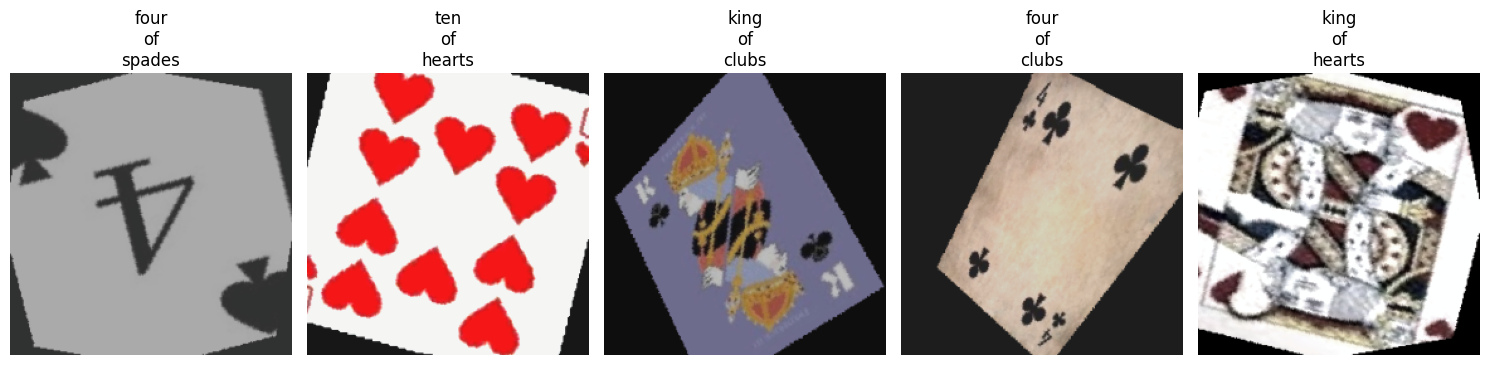

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

def show_dataset_samples(dataset, num_samples=5):
    inv_suit_map = {v: k for k, v in dataset.suit_map.items()}
    inv_rank_map = {v: k for k, v in dataset.rank_map.items()}
    
    plt.figure(figsize=(15, 5))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, suit_idx, rank_idx = dataset[idx]
        
        img_display = image.permute(1, 2, 0).numpy()
        img_display = img_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_display = np.clip(img_display, 0, 1)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_display)
        plt.title(f"{inv_rank_map[rank_idx]}\nof\n{inv_suit_map[suit_idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_samples(train_loader.dataset)

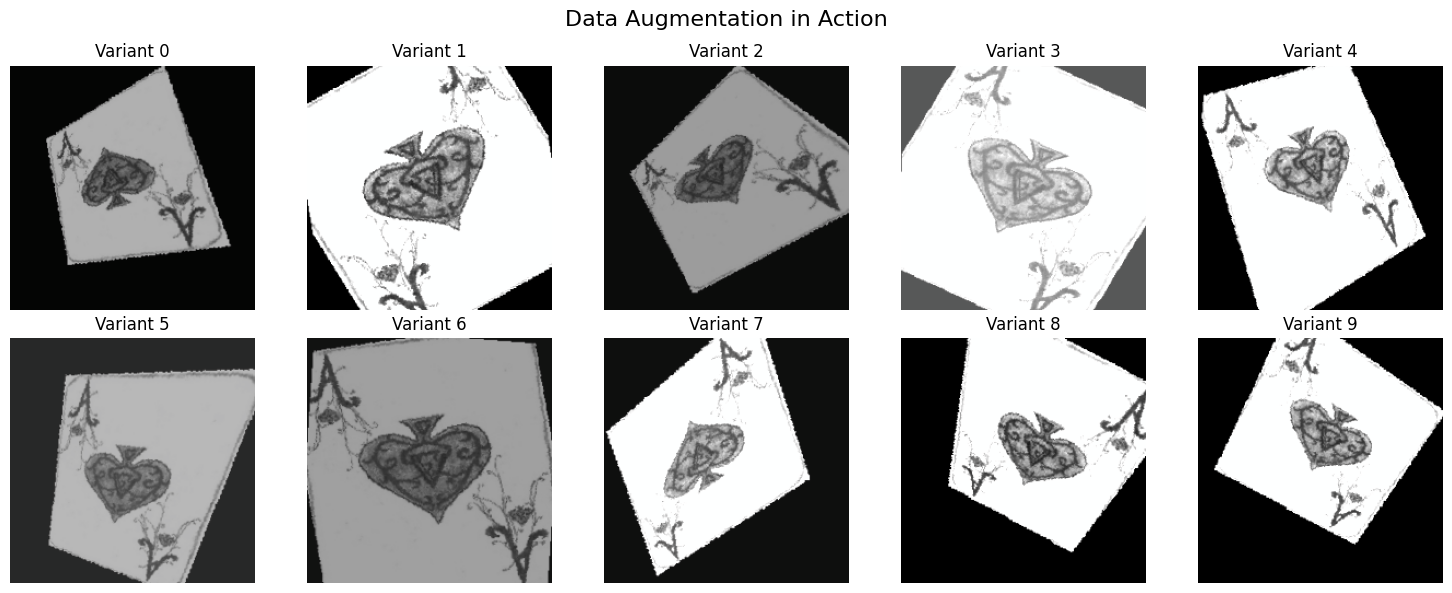

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2
import torch


train_tfs = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
    transforms.RandomAffine(degrees=30, shear=10),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.7, hue=0.015),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) 
train_loader = DataLoader(
    PlayingCardDataset(train_df, data_root, train_tfs), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

def visualize_augmentations(dataset, idx=0, num_samples=10):
    # Setup the plot
    plt.figure(figsize=(15, 6))
    plt.suptitle("Data Augmentation in Action", fontsize=16)
    
    for i in range(num_samples):
        image, suit_idx, rank_idx = dataset[idx]
        
        img_display = image.permute(1, 2, 0).numpy()
        img_display = img_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_display = np.clip(img_display, 0, 1)
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f"Variant {i}")

    plt.tight_layout()
    plt.show()

visualize_augmentations(train_loader.dataset, idx=451)

In [ ]:
import json
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# --- CONFIG ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
PATIENCE = 15
writer = SummaryWriter('runs/card_experiment')

# --- MODEL SETUP ---
model = CardNet(num_suits=5, num_ranks=14).to(DEVICE)
model.load_state_dict(torch.load('best_cardnet.pth'))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0005)
# Don't forgot to update the learning rate if resuming from a checkpoint
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.1,
    patience=7,
)

# --- TRAINING LOOP WITH EARLY STOPPING ---
best_loss = float('inf')
best_loss = float(1.1879701256752013)
counter = 0


for epoch in range(41,100):
    # --- TRAINING ---
    model.train()
    train_loss = 0.0
    train_correct_s, train_correct_r, train_total = 0, 0, 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{100}", unit="batch")

    for imgs, suits, ranks in train_pbar:
        imgs, suits, ranks = imgs.to(DEVICE), suits.to(DEVICE), ranks.to(DEVICE)
        
        optimizer.zero_grad()
        s_out, r_out = model(imgs)
        loss_s = criterion(s_out, suits)
        loss_r = criterion(r_out, ranks)
        loss = loss_s + loss_r
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        s_preds = s_out.argmax(1)
        r_preds = r_out.argmax(1)
        
        train_correct_s += (s_preds == suits).sum().item()
        train_correct_r += (r_preds == ranks).sum().item()
        train_total += suits.size(0)
        
        train_pbar.set_postfix({
            'loss': f"{loss.item():.3f}",
            's_acc': f"{(s_preds == suits).float().mean().item()*100:.1f}%",
            'r_acc': f"{(r_preds == ranks).float().mean().item()*100:.1f}%"
        })

    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    val_correct_s, val_correct_r, val_total = 0, 0, 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Valid]", unit="batch", leave=False)
    with torch.no_grad():
        
        for imgs, suits, ranks in val_pbar:
            imgs, suits, ranks = imgs.to(DEVICE), suits.to(DEVICE), ranks.to(DEVICE)
            s_out, r_out = model(imgs)
            batch_loss = (criterion(s_out, suits) + criterion(r_out, ranks)).item()
            val_loss += batch_loss
            
            val_correct_s += (s_out.argmax(1) == suits).sum().item()
            val_correct_r += (r_out.argmax(1) == ranks).sum().item()
            val_total += suits.size(0)
            
            val_pbar.set_postfix({'loss': f"{batch_loss:.3f}"})

    
    # Calculate Epoch Summaries
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_suit_acc = (val_correct_s / val_total) * 100
    val_rank_acc = (val_correct_r / val_total) * 100
    
    # --- LOGGING TO TENSORBOARD ---
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    writer.add_scalars('Loss/Comparison', {
    'Train': avg_train_loss,
    'Validation': avg_val_loss
    }, epoch)
    writer.add_scalar('Accuracy/Val_Suit', val_suit_acc, epoch)
    writer.add_scalar('Accuracy/Val_Rank', val_rank_acc, epoch)
    writer.add_scalar('Params/Learning_Rate', optimizer.param_groups[0]['lr'], epoch)

    print(f"\n[FINISH EPOCH {epoch+1}] Val Loss: {avg_val_loss:.4f} | Train Loss: {avg_train_loss:.4f} | Suit Acc: {val_suit_acc:.1f}% | Rank Acc: {val_rank_acc:.1f}%")

    scheduler.step(avg_val_loss)

    # Checkpoint & Early Stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_cardnet.pth')
        counter = 0
        print("--> Model Saved")
    else:
        counter += 1
        if counter >= PATIENCE:
            print("Early Stopping.")
            break

    # Save training status to JSON
    status = {
        "last_completed_epoch": epoch + 1,
        "best_val_loss": float(best_loss),
        "current_val_loss": float(avg_val_loss),
        "val_suit_acc": float(val_suit_acc),
        "val_rank_acc": float(val_rank_acc),
        "learning_rate": float(optimizer.param_groups[0]['lr'])
    }
    with open('training_status.json', 'w') as f:
        json.dump(status, f, indent=4)

writer.close()

Using device: cuda


Epoch 31/100: 100%|██████████| 120/120 [03:35<00:00,  1.79s/batch, loss=2.107, s_acc=62.5%, r_acc=75.0%]



[FINISH EPOCH 31] Val Loss: 1.4287 | Train Loss: 1.6694 | Suit Acc: 87.2% | Rank Acc: 67.2%


Epoch 32/100: 100%|██████████| 120/120 [03:20<00:00,  1.67s/batch, loss=3.325, s_acc=62.5%, r_acc=37.5%]



[FINISH EPOCH 32] Val Loss: 1.4096 | Train Loss: 1.6427 | Suit Acc: 87.9% | Rank Acc: 63.0%
--> Model Saved


Epoch 33/100: 100%|██████████| 120/120 [03:25<00:00,  1.71s/batch, loss=1.709, s_acc=87.5%, r_acc=50.0%]



[FINISH EPOCH 33] Val Loss: 1.3454 | Train Loss: 1.6109 | Suit Acc: 89.1% | Rank Acc: 64.2%
--> Model Saved


Epoch 34/100: 100%|██████████| 120/120 [03:18<00:00,  1.66s/batch, loss=1.530, s_acc=75.0%, r_acc=37.5%]



[FINISH EPOCH 34] Val Loss: 1.3461 | Train Loss: 1.5829 | Suit Acc: 89.8% | Rank Acc: 61.5%


Epoch 35/100: 100%|██████████| 120/120 [03:20<00:00,  1.67s/batch, loss=1.914, s_acc=87.5%, r_acc=37.5%]



[FINISH EPOCH 35] Val Loss: 1.2943 | Train Loss: 1.5316 | Suit Acc: 90.9% | Rank Acc: 68.3%
--> Model Saved


Epoch 36/100: 100%|██████████| 120/120 [03:24<00:00,  1.70s/batch, loss=1.561, s_acc=75.0%, r_acc=62.5%]



[FINISH EPOCH 36] Val Loss: 1.4353 | Train Loss: 1.5213 | Suit Acc: 83.8% | Rank Acc: 70.2%


Epoch 37/100: 100%|██████████| 120/120 [03:26<00:00,  1.72s/batch, loss=2.459, s_acc=62.5%, r_acc=50.0%]



[FINISH EPOCH 37] Val Loss: 1.3117 | Train Loss: 1.4838 | Suit Acc: 92.1% | Rank Acc: 63.4%


Epoch 38/100: 100%|██████████| 120/120 [03:26<00:00,  1.72s/batch, loss=0.977, s_acc=100.0%, r_acc=87.5%]



[FINISH EPOCH 38] Val Loss: 1.2043 | Train Loss: 1.4810 | Suit Acc: 90.2% | Rank Acc: 71.7%
--> Model Saved


Epoch 39/100: 100%|██████████| 120/120 [03:42<00:00,  1.85s/batch, loss=1.614, s_acc=75.0%, r_acc=62.5%]



[FINISH EPOCH 39] Val Loss: 1.2028 | Train Loss: 1.4386 | Suit Acc: 87.9% | Rank Acc: 72.1%
--> Model Saved


Epoch 40/100: 100%|██████████| 120/120 [03:24<00:00,  1.71s/batch, loss=1.934, s_acc=75.0%, r_acc=37.5%]



[FINISH EPOCH 40] Val Loss: 1.5063 | Train Loss: 1.4332 | Suit Acc: 75.8% | Rank Acc: 70.6%


Epoch 41/100: 100%|██████████| 120/120 [03:24<00:00,  1.70s/batch, loss=2.728, s_acc=50.0%, r_acc=50.0%]



[FINISH EPOCH 41] Val Loss: 1.1880 | Train Loss: 1.4210 | Suit Acc: 89.4% | Rank Acc: 70.9%
--> Model Saved


Epoch 42/100:   9%|▉         | 11/120 [00:21<03:32,  1.95s/batch, loss=1.133, s_acc=87.5%, r_acc=75.0%]


KeyboardInterrupt: 

Running Comprehensive Evaluation...

FINAL PERFORMANCE SUMMARY
SUIT REPORT:
              precision    recall  f1-score   support

       clubs       0.95      0.94      0.95        65
    diamonds       0.83      0.97      0.89        65
      hearts       0.95      0.82      0.88        65
      spades       0.85      0.88      0.86        65
       joker       0.50      0.20      0.29         5

    accuracy                           0.89       265
   macro avg       0.82      0.76      0.77       265
weighted avg       0.89      0.89      0.88       265

RANK REPORT:
              precision    recall  f1-score   support

         two       1.00      0.70      0.82        20
       three       0.89      0.80      0.84        20
        four       0.84      0.80      0.82        20
        five       0.75      0.75      0.75        20
         six       0.78      0.70      0.74        20
       seven       0.83      0.75      0.79        20
       eight       0.68      0.75      0.71

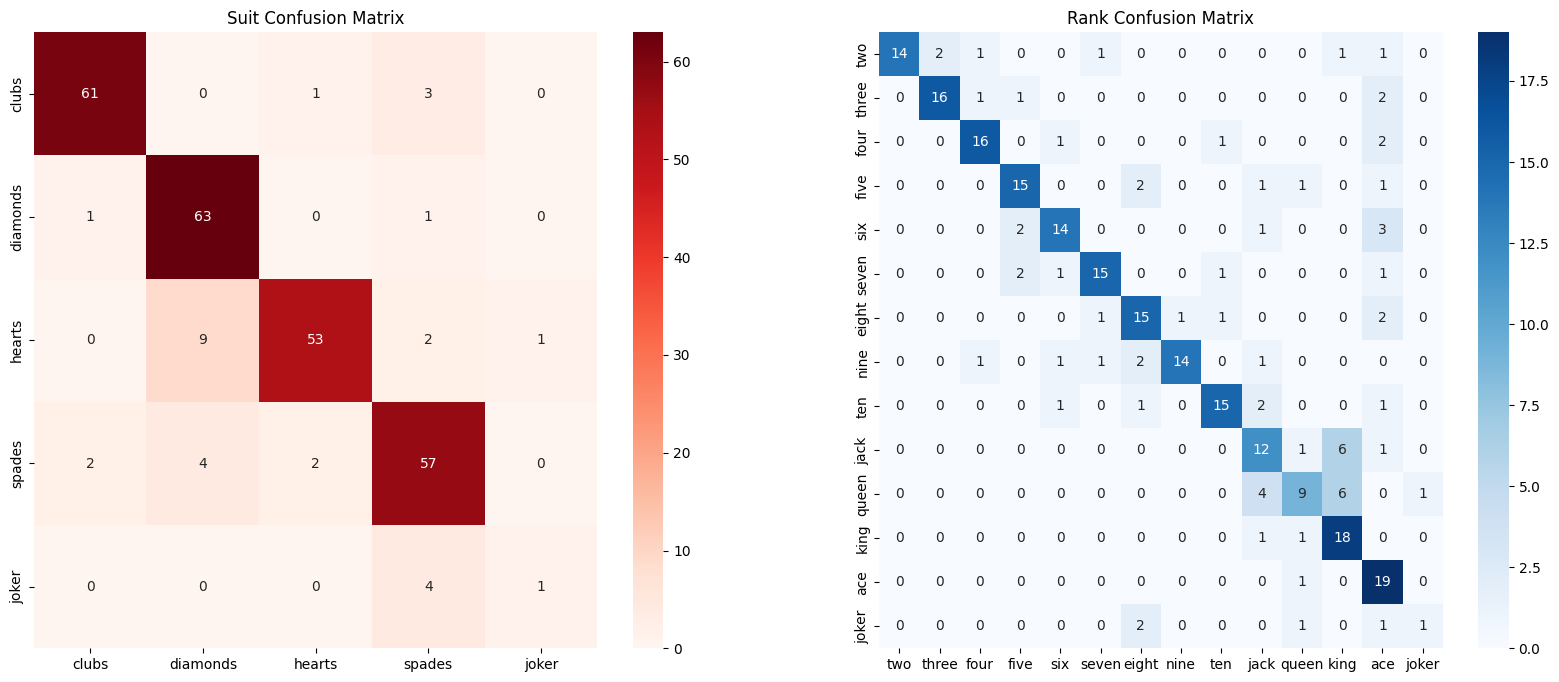


Displaying 30 Suit Errors:


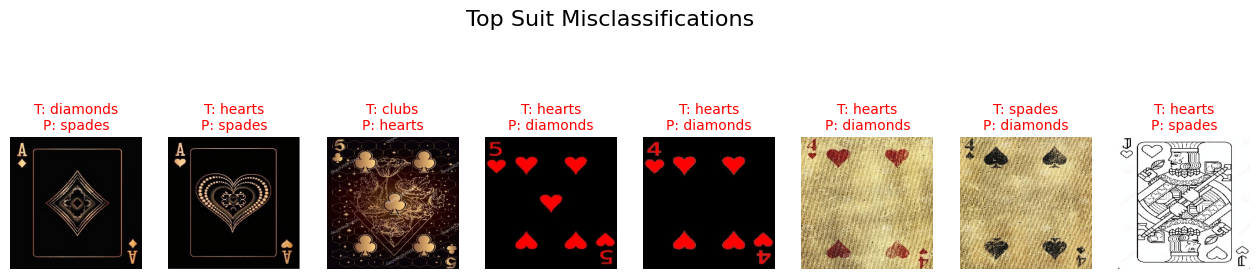


Displaying 72 Rank Errors:


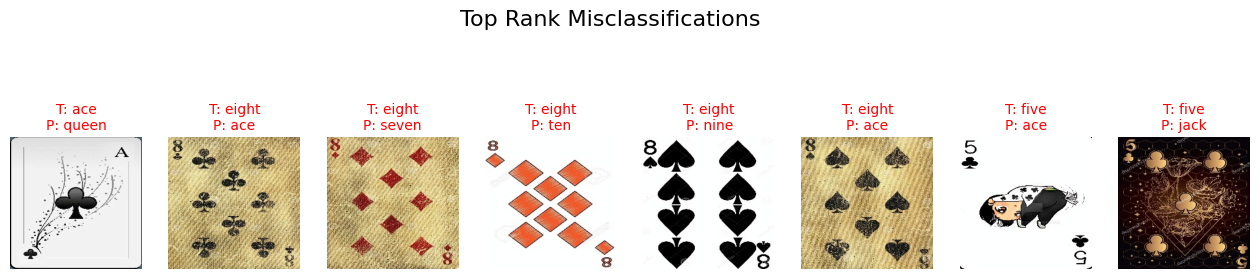

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

suit_names = ['clubs', 'diamonds', 'hearts', 'spades', 'joker']
rank_names = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'ace', 'joker']

all_s_preds, all_s_labels = [], []
all_r_preds, all_r_labels = [], []
suit_errors, rank_errors = [], []

model.load_state_dict(torch.load('best_cardnet.pth', map_location=DEVICE))
model.eval()

print("Running Comprehensive Evaluation...")
with torch.no_grad():
    for images, s_labels, r_labels in test_loader:
        images_gpu = images.to(DEVICE)
        s_out, r_out = model(images_gpu)
        
        s_preds = torch.argmax(s_out, 1).cpu().numpy()
        r_preds = torch.argmax(r_out, 1).cpu().numpy()
        
        s_actual = s_labels.numpy()
        r_actual = r_labels.numpy()
        
        all_s_preds.extend(s_preds)
        all_s_labels.extend(s_actual)
        all_r_preds.extend(r_preds)
        all_r_labels.extend(r_actual)
        
        for i in range(len(images)):
            if s_preds[i] != s_actual[i]:
                suit_errors.append({
                    'img': images[i], 'p': suit_names[s_preds[i]], 
                    't': suit_names[s_actual[i]], 'card': rank_names[r_actual[i]]
                })
            if r_preds[i] != r_actual[i]:
                rank_errors.append({
                    'img': images[i], 'p': rank_names[r_preds[i]], 
                    't': rank_names[r_actual[i]], 'suit': suit_names[s_actual[i]]
                })

def show_errors(error_list, title, type_name):
    if not error_list:
        print(f"\nNo {type_name} errors found!")
        return
    print(f"\nDisplaying {len(error_list)} {type_name} Errors:")
    count = min(len(error_list), 8)
    plt.figure(figsize=(16, 4))
    for i in range(count):
        err = error_list[i]
        plt.subplot(1, 8, i + 1)
        img = err['img'].permute(1, 2, 0).numpy()
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
        plt.imshow(img)
        plt.title(f"T: {err['t']}\nP: {err['p']}", color='red', fontsize=10)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

print("\n" + "="*30 + "\nFINAL PERFORMANCE SUMMARY\n" + "="*30)
print(f"SUIT REPORT:\n{classification_report(all_s_labels, all_s_preds, target_names=suit_names)}")
print(f"RANK REPORT:\n{classification_report(all_r_labels, all_r_preds, target_names=rank_names)}")

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(confusion_matrix(all_s_labels, all_s_preds), annot=True, fmt='d', cmap='Reds', 
            xticklabels=suit_names, yticklabels=suit_names, ax=ax[0])
ax[0].set_title('Suit Confusion Matrix')

sns.heatmap(confusion_matrix(all_r_labels, all_r_preds), annot=True, fmt='d', cmap='Blues', 
            xticklabels=rank_names, yticklabels=rank_names, ax=ax[1])
ax[1].set_title('Rank Confusion Matrix')
plt.show()

show_errors(suit_errors, "Top Suit Misclassifications", "Suit")
show_errors(rank_errors, "Top Rank Misclassifications", "Rank")

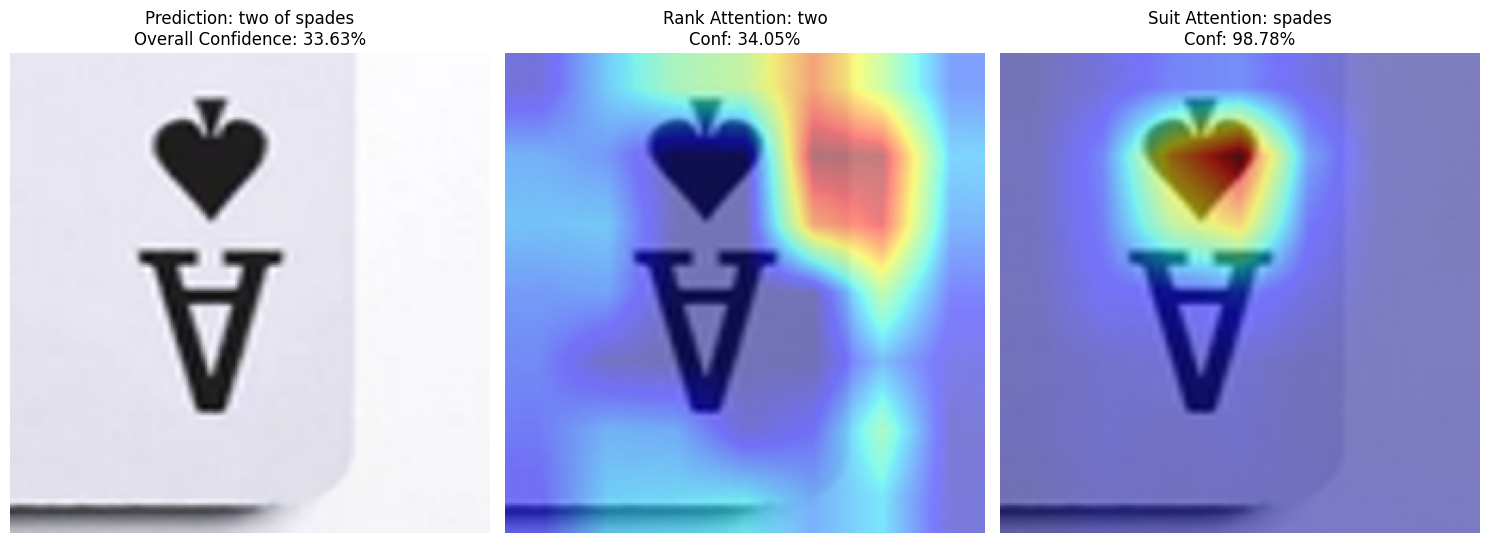

In [24]:
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

import cv2
import numpy as np
import torch


def get_gradcam_heatmap(model, input_tensor, target_class_idx, head_type='rank'):
    feature_maps = []
    gradients = []

    def forward_hook(module, input, output):
        feature_maps.append(output)
    
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    target_layer = model.layer4[-1]
    
    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_backward_hook(backward_hook)

    model.zero_grad()
    suit_out, rank_out = model(input_tensor)
    
    output = rank_out if head_type == 'rank' else suit_out
    score = output[0, target_class_idx]
    score.backward()

    grads = gradients[0].cpu().data.numpy()
    f_maps = feature_maps[0].cpu().data.numpy()[0]
    
    weights = np.mean(grads, axis=(2, 3))[0]
    cam = np.zeros(f_maps.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * f_maps[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    
    h1.remove()
    h2.remove()
    
    return cam



def test_on_image_with_heatmap(image_path, model, transform, device):
    suit_names = ['clubs', 'diamonds', 'hearts', 'spades', 'joker']
    rank_names = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'ace', 'joker']
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    input_tensor.requires_grad = True 
    
    model.eval()
    
    suit_out, rank_out = model(input_tensor)
    
    suit_probs = torch.nn.functional.softmax(suit_out, dim=1)
    rank_probs = torch.nn.functional.softmax(rank_out, dim=1)
    
    s_conf, s_idx = torch.max(suit_probs, 1)
    r_conf, r_idx = torch.max(rank_probs, 1)
    
    s_idx, s_conf = s_idx.item(), s_conf.item()
    r_idx, r_conf = r_idx.item(), r_conf.item()
    
    rank_heatmap = get_gradcam_heatmap(model, input_tensor, r_idx, head_type='rank')
    suit_heatmap = get_gradcam_heatmap(model, input_tensor, s_idx, head_type='suit')

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image.resize((224, 224)))
    plt.title(f"Prediction: {rank_names[r_idx]} of {suit_names[s_idx]}\n"
              f"Overall Confidence: {(r_conf * s_conf):.2%}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image.resize((224, 224)))
    plt.imshow(rank_heatmap, cmap='jet', alpha=0.5)
    plt.title(f"Rank Attention: {rank_names[r_idx]}\nConf: {r_conf:.2%}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image.resize((224, 224)))
    plt.imshow(suit_heatmap, cmap='jet', alpha=0.5)
    plt.title(f"Suit Attention: {suit_names[s_idx]}\nConf: {s_conf:.2%}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


model = CardNet(num_suits=5, num_ranks=14).to(DEVICE)
model.load_state_dict(torch.load('best_cardnet.pth', map_location=DEVICE))
my_image_path = "image.png"
test_on_image_with_heatmap(my_image_path, model, val_tfs, DEVICE)